Ref: https://blog.naver.com/fkdldjs60/221890766482

# Part 1. Importing Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import missingno

import sys
import warnings

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def cross_validator(estimator, X_train, y_train, scoring="accuracy", cv=10, n_jobs=1):
    scores = cross_val_score(estimator, X=X_train, y=y_train, scoring=scoring, cv=cv, n_jobs=n_jobs)
    print(np.round(scores,3), '->', np.round(scores.mean(),3), '|', np.round(scores.std(),3))
    #print("Mean score: {0:.4f} | std: {1:.4f}".format(scores.mean(), scores.std()))
    
    
def grid_search(estimator, params, X, y, scoring='accuracy', cv=10, n_jobs=-1, verbose=1):

    grid_clf = GridSearchCV(estimator, param_grid=params, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_clf.fit(X, y)

    print(grid_clf.best_params_, grid_clf.best_score_)
    
    return grid_clf

# Part 2. Loading Training and Test Sets

In [3]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# Part 3. EDA and Feature Engineering

## Step 1. Only Using Numeric Features

In [6]:
numeric = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [7]:
train[numeric+['Survived']]

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
0,1,3,22.0,1,0,7.2500,0
1,2,1,38.0,1,0,71.2833,1
2,3,3,26.0,0,0,7.9250,1
3,4,1,35.0,1,0,53.1000,1
4,5,3,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...
886,887,2,27.0,0,0,13.0000,0
887,888,1,19.0,0,0,30.0000,1
888,889,3,NaN,1,2,23.4500,0
889,890,1,26.0,0,0,30.0000,1


In [8]:
test[numeric]

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,892,3,34.5,0,0,7.8292
1,893,3,47.0,1,0,7.0000
2,894,2,62.0,0,0,9.6875
3,895,3,27.0,0,0,8.6625
4,896,3,22.0,1,1,12.2875
...,...,...,...,...,...,...
413,1305,3,NaN,0,0,8.0500
414,1306,1,39.0,0,0,108.9000
415,1307,3,38.5,0,0,7.2500
416,1308,3,NaN,0,0,8.0500


In [9]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

In [10]:
X_train = train[numeric]
y_train = train['Survived']
X_test = test[numeric]

In [11]:
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].mean())

In [12]:
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].mean())
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].mean())

In [13]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [14]:
predictions = model.predict(X_test)

In [15]:
submit = pd.read_csv('./gender_submission.csv')
submit['Survived'] = predictions
submit.to_csv('Step1_prediction.csv', index=False)

## Step 2. Including String-type Features

In [16]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [17]:
train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [18]:
train['Sex_encode'] = train['Sex'].replace('male',0).replace('female',1)

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_encode
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [20]:
test['Sex_encode'] = test['Sex'].replace('male',0).replace('female',1)

In [21]:
train['Embarked_encode'] = train['Embarked'].replace('S',0).replace('C',1).replace('Q',2)

In [22]:
test['Embarked_encode'] = test['Embarked'].replace('S',0).replace('C',1).replace('Q',2)

In [23]:
features = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_encode', 'Embarked_encode']
X_train = train[features]
X_test  = test[features]
y_train = train['Survived']

In [24]:
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].mean())

In [25]:
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].mean())
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].mean())

In [26]:
X_train['Embarked_encode'] = X_train['Embarked_encode'].fillna(0)

In [27]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

submit = pd.read_csv('./gender_submission.csv')
submit['Survived'] = predictions
submit.to_csv('Step2_prediction.csv', index=False)

## Step 3. Using Feature Correlations

In [90]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [91]:
train['Sex_encode'] = train['Sex'].replace('male',0).replace('female',1)
test['Sex_encode'] = test['Sex'].replace('male',0).replace('female',1)
train['Embarked_encode'] = train['Embarked'].replace('S',0).replace('C',1).replace('Q',2)
test['Embarked_encode'] = test['Embarked'].replace('S',0).replace('C',1).replace('Q',2)

In [92]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_encode,Embarked_encode
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.042939,-0.030555
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.543351,0.108669
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.131900,0.043835
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.093254,0.012186
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.114631,-0.060606
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.245489,-0.079320
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.182333,0.063462
Sex_encode,-0.042939,0.543351,-0.131900,-0.093254,0.114631,0.245489,0.182333,1.000000,0.118593
Embarked_encode,-0.030555,0.108669,0.043835,0.012186,-0.060606,-0.079320,0.063462,0.118593,1.000000


In [93]:
features = ['Pclass', 'Fare', 'Sex_encode', 'Embarked_encode']
X_train = train[features]
X_test  = test[features]
y_train = train['Survived']

In [94]:
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].mean())
X_train['Embarked_encode'] = X_train['Embarked_encode'].fillna(0)

In [95]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

submit = pd.read_csv('./gender_submission.csv')
submit['Survived'] = predictions
submit.to_csv('Step3_correlation.csv', index=False)

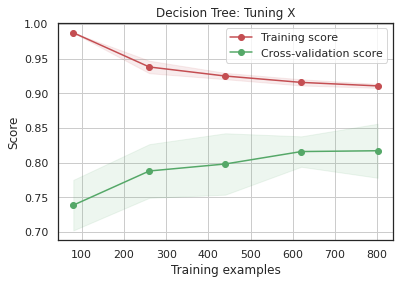

In [96]:
g = plot_learning_curve(model, "Decision Tree: Tuning X", X_train, y_train, cv=10)

## Step 4. Hyper Parameter Tuning

In [97]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=10, max_features=0.9)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

submit = pd.read_csv('./gender_submission.csv')
submit['Survived'] = predictions
submit.to_csv('Step4_hyper_parameter_tuning.csv', index=False)

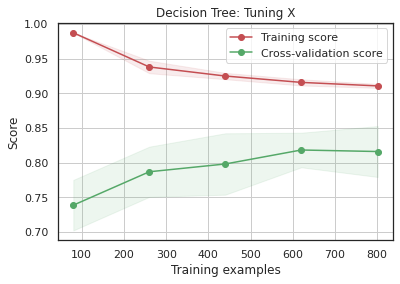

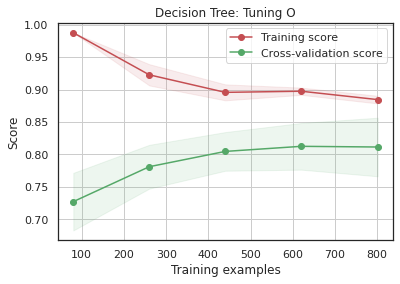

In [45]:
g = plot_learning_curve(DecisionTreeClassifier(), 
                        "Decision Tree: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(model, "Decision Tree: Tuning O", X_train, y_train, cv=10)

In [46]:
cross_validator(DecisionTreeClassifier(), X_train, y_train, scoring="accuracy", cv=10, n_jobs=1)
cross_validator(model, X_train, y_train, scoring="accuracy", cv=10, n_jobs=1)

[0.767 0.764 0.764 0.82  0.899 0.843 0.82  0.809 0.843 0.82 ] -> 0.815 | 0.04
[0.822 0.798 0.753 0.82  0.91  0.831 0.809 0.809 0.809 0.831] -> 0.819 | 0.037


In [36]:
rf_clf = RandomForestClassifier(n_estimators=400)
cross_validator(rf_clf, X_train, y_train, scoring="accuracy", cv=10, n_jobs=1)

[0.756 0.764 0.764 0.809 0.91  0.798 0.82  0.809 0.854 0.809] -> 0.809 | 0.044


In [39]:
rf_clf = RandomForestClassifier()
params = {"max_depth": [None],
          "max_features": [1, 3, 5],
          "min_samples_split": [2, 3, 10],
          "min_samples_leaf": [1, 3, 10],
          "bootstrap": [False],
          "n_estimators" :[100,300],
          "criterion": ["gini"]}

rf_grid_clf = grid_search(rf_clf, params, X_train, y_train, scoring='accuracy', cv=10, n_jobs=6, verbose=1)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100} 0.8159800249687891


In [40]:
rf_best = rf_grid_clf.best_estimator_

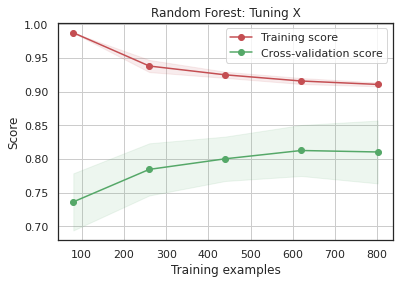

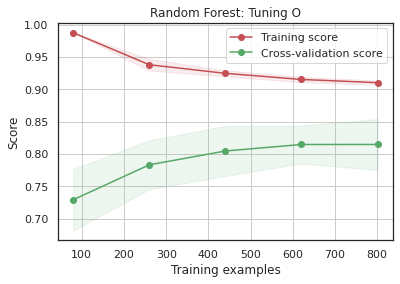

In [47]:
g = plot_learning_curve(RandomForestClassifier(n_estimators=1000), 
                        "Random Forest: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(rf_best, "Random Forest: Tuning O", X_train, y_train, cv=10)

In [42]:
cross_validator(rf_best, X_train, y_train, n_jobs=6)

[0.767 0.798 0.775 0.798 0.899 0.82  0.82  0.798 0.854 0.82 ] -> 0.815 | 0.037


In [50]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier()
params = {"max_depth": [-1, 10, 20],
          "learning_rate":[0.03, 0.1, 0.3],
          "min_child_samples": [5, 10, 20, 30],
          "num_leaves":[31, 50],
          "subsample":[1.0],
          "colsample_bytree":[1.0],
          "reg_lambda":[0.0],
          "reg_alpha":[0.0],
          "n_estimators" :[100, 200, 300]}


lgbm_grid_clf = grid_search(lgbm_clf, params, X_train, y_train, scoring='accuracy', cv=10, n_jobs=6, verbose=1)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 30, 'n_estimators': 200, 'num_leaves': 31, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0} 0.8227340823970037


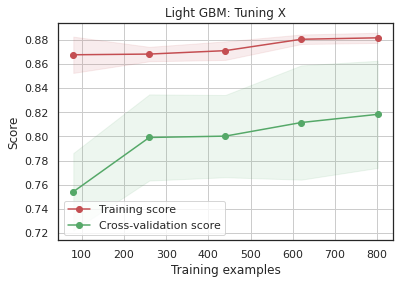

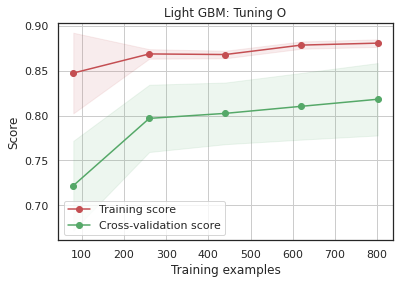

In [51]:
lgbm_best = lgbm_grid_clf.best_estimator_
g = plot_learning_curve(LGBMClassifier(), 
                        "Light GBM: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(lgbm_best, "Light GBM: Tuning O", X_train, y_train, cv=10)

In [52]:
cross_validator(LGBMClassifier(), X_train, y_train, n_jobs=6)
cross_validator(lgbm_best, X_train, y_train, n_jobs=6)

[0.767 0.809 0.764 0.775 0.899 0.82  0.843 0.82  0.82  0.82 ] -> 0.814 | 0.038
[0.767 0.831 0.764 0.809 0.933 0.82  0.843 0.798 0.843 0.82 ] -> 0.823 | 0.045


In [56]:
lr_clf = LogisticRegression()
params = {'penalty':['l2', 'l1', 'elasticnet'],
          'C':[0.01, 0.03, 0.1, 0.3, 1, 3, 10],
          'l1_ratio':[0.01, 0.03, 0.1, 0.3, 1, 10]}

lr_grid_clf = grid_search(lr_clf, params, X_train, y_train, scoring='accuracy', cv=10, n_jobs=6, verbose=1)

Fitting 10 folds for each of 126 candidates, totalling 1260 fits
{'C': 0.03, 'l1_ratio': 0.01, 'penalty': 'l2'} 0.7991385767790262


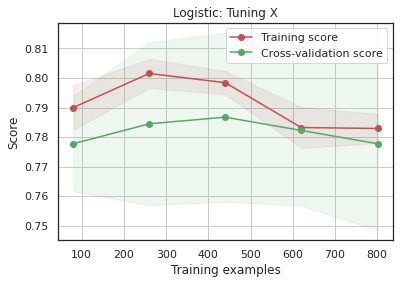

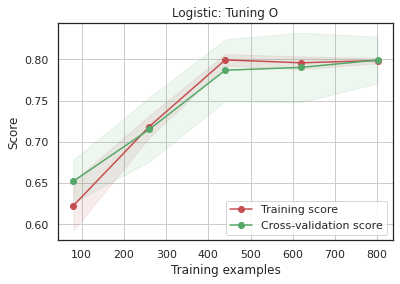

In [57]:
lr_best = lr_grid_clf.best_estimator_
g = plot_learning_curve(LogisticRegression(), 
                        "Logistic: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(lr_best, "Logistic: Tuning O", X_train, y_train, cv=10)

In [58]:
cross_validator(LogisticRegression(), X_train, y_train, n_jobs=6)
cross_validator(lr_best, X_train, y_train, n_jobs=6)

[0.8   0.775 0.753 0.843 0.764 0.775 0.753 0.742 0.809 0.764] -> 0.778 | 0.029
[0.767 0.787 0.775 0.854 0.831 0.775 0.82  0.787 0.82  0.775] -> 0.799 | 0.028


# Step 5. Adding New Features

In [131]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [132]:
train['Sex'] = train['Sex'].replace('male',0).replace('female',1)
test['Sex'] = test['Sex'].replace('male',0).replace('female',1)

train['Embarked'] = train['Embarked'].fillna('S')

In [133]:
train['Embarked_Q'] = train['Embarked']=='Q'
train['Embarked_S'] = train['Embarked']=='S'
train['Embarked_C'] = train['Embarked']=='C'

In [134]:
test['Embarked_Q'] = test['Embarked']=='Q'
test['Embarked_S'] = test['Embarked']=='S'
test['Embarked_C'] = test['Embarked']=='C'

In [135]:
train["Family"] = train['SibSp'] + train['Parch'] + 1
test["Family"]  = test['SibSp']  + test['Parch'] + 1

<AxesSubplot:xlabel='Family', ylabel='count'>

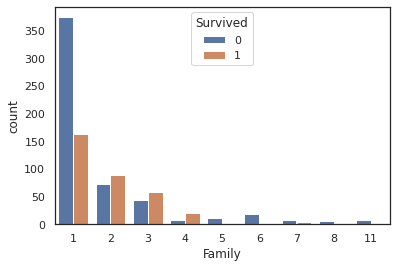

In [136]:
sns.countplot(data=train, x='Family', hue='Survived')

In [137]:
def Family_type(Family):
    if Family==1:
        return 'Single'
    elif Family>1 and Family<5:
        return 'Nuclear'
    else:
        return 'Big'

In [138]:
train['Family_type'] = train['Family'].apply(Family_type)

In [139]:
train[['Family', 'Family_type']].head()

,Family,Family_type
0,2,Nuclear
1,2,Nuclear
2,1,Single
3,2,Nuclear
4,1,Single


In [140]:
test['Family_type'] = test['Family'].apply(Family_type)

In [141]:
train['Single']  = train['Family_type'] == 'Single'
train['Nuclear'] = train['Family_type'] == 'Nuclear'
train['Big']     = train['Family_type'] == 'Big'

In [142]:
test['Single']  = test['Family_type'] == 'Single'
test['Nuclear'] = test['Family_type'] == 'Nuclear'
test['Big']     = test['Family_type'] == 'Big'

In [143]:
train.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Sex            0.543351
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Embarked_Q     0.003650
Embarked_S    -0.155660
Embarked_C     0.168240
Family         0.016639
Single        -0.203367
Nuclear        0.279855
Big           -0.125147
Name: Survived, dtype: float64

test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

In [144]:
test['Fare'] = test['Fare'].fillna(0)

In [145]:
features = ['Pclass', 'Sex', 'Fare', 'Embarked_Q', 'Embarked_S', 'Embarked_C', 'Single', 'Nuclear', 'Big']

In [146]:
X_train = train[features]
X_test  = test[features]
y_train = train['Survived']

In [147]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=10, max_features=0.9)

In [122]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10)

print(np.round(scores, 4))
print(np.round(scores.mean(),4))

[0.7889 0.8539 0.7753 0.7753 0.9101 0.8427 0.809  0.7865 0.8202 0.8202]
0.8182


In [123]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

submit = pd.read_csv('./gender_submission.csv')
submit['Survived'] = predictions
submit.to_csv('Step5_adding_new_features.csv', index=False)

In [125]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
params = {'penalty':['l2', 'l1', 'elasticnet'],
          'C':[0.01, 0.03, 0.1, 0.3, 1, 3, 10],
          'l1_ratio':[0.01, 0.03, 0.1, 0.3, 1, 10]}

lr_grid_clf = grid_search(lr_clf, params, X_train, y_train, scoring='accuracy', cv=10, n_jobs=6, verbose=1)

Fitting 10 folds for each of 126 candidates, totalling 1260 fits
{'C': 0.3, 'l1_ratio': 0.01, 'penalty': 'l2'} 0.8036204744069912


In [127]:
lr_best = lr_grid_clf.best_estimator_
cross_validator(lr_best, X_train, y_train, n_jobs=6)

[0.778 0.82  0.764 0.831 0.82  0.787 0.82  0.787 0.831 0.798] -> 0.804 | 0.023


In [148]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier()
params = {"max_depth": [-1, 10, 20],
          "learning_rate":[0.03, 0.1, 0.3],
          "min_child_samples": [5, 10, 20, 30],
          "num_leaves":[31, 50],
          "subsample":[1.0],
          "colsample_bytree":[1.0],
          "reg_lambda":[0.0],
          "reg_alpha":[0.0],
          "n_estimators" :[100, 200, 300]}


lgbm_grid_clf = grid_search(lgbm_clf, params, X_train, y_train, scoring='accuracy', cv=10, n_jobs=6, verbose=1)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
{'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 20, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 50, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0} 0.823832709113608


In [149]:
lgbm_best = lgbm_grid_clf.best_estimator_
cross_validator(lgbm_best, X_train, y_train, n_jobs=6)

[0.789 0.82  0.753 0.854 0.91  0.82  0.854 0.787 0.854 0.798] -> 0.824 | 0.043


In [150]:
lgbm_best.fit(X_train, y_train)
predictions = lgbm_best.predict(X_test)

submit = pd.read_csv('./gender_submission.csv')
submit['Survived'] = predictions
submit.to_csv('Step5_adding_new_features_lgbm.csv', index=False)